In [1]:
import sys
sys.path.insert(0, '../../../Utilities/')
import argparse
import os
import torch
from collections import OrderedDict
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
# from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import seaborn as sns
import pylab as py
import time
from doe_lhs import *
import warnings
sys.path.insert(0, '../../../Scripts/')
from models_pde import Net
# from adaptive_t import *
from s_pid import *
# from ../Scripts/helper import *

warnings.filterwarnings('ignore')

np.random.seed(1234)

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

## Hyper-parameters

In [3]:
num_epochs = 30000
lambda_phy = 1

noise = 0.0

## Network Architecture
hid_dim = 20
num_layer = 8

## Load Data

In [4]:
N_u = 25
N_i = 100
N_f = 5000
data = scipy.io.loadmat('../../../datasets/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None] 

st = 0.30
tt = int(t.shape[0] * st)

trunk1_X = X_star[ : x.shape[0] * tt]
trunk2_X = X_star[x.shape[0] * (tt - 1) : ]

trunk1_u = u_star[ : x.shape[0] * tt]
trunk2_u = u_star[x.shape[0] * (tt - 1) : ]




In [5]:
lb = X_star.min(0)  # [-1.  0.]
ub = X_star.max(0)  # [1.   0.99]

first_lb = trunk1_X.min(0) # [-1.  0.] 
first_ub = trunk1_X.max(0) # [1.   0.49]

second_lb = trunk2_X.min(0) # [-1.    0.49]
second_ub = trunk2_X.max(0) # [1.   0.99]


# --------------------- first half ---------------------

# initial conditions t = 0 for first half
xx1_1 = X_star[0:256]
uu1_1 = u_star[0:256]

# boundary conditions x = lb 
xx2_1 = np.hstack((X[0:tt,0:1], T[0:tt,0:1]))
uu2_1 = np.zeros_like(Exact[0:tt,0:1])

# boundary conditions, x = ub 
xx3_1 = np.hstack((X[:tt,-1:], T[:tt,-1:]))
uu3_1 = np.zeros_like(Exact[:tt,-1:])

# boundary points
X_u_train_1 = np.vstack([xx2_1, xx3_1]) 
u_train_1 = np.vstack([uu2_1, uu3_1])

# collocation points 
X_f_train_1 = first_lb + (first_ub-first_lb)*lhs(2, N_f)


# selecting N_u boundary points for training
idx = np.random.choice(X_u_train_1.shape[0], N_u, replace=False)
X_u_train_1 = X_u_train_1[idx, :]
u_train_1 = u_train_1[idx,:]

# selecting N_i initial points for training
idx_x = np.random.choice(xx1_1.shape[0], N_i, replace=False)
X_i_train_1 = xx1_1[idx_x, :]
u_i_train_1 = uu1_1[idx_x, :]

# adding boundary and initial points
X_u_train_1 = np.vstack([X_u_train_1, X_i_train_1])
u_train_1 = np.vstack([u_train_1, u_i_train_1])

# --------------------- second half ---------------------


# initial conditions t = 0.49
xx1_2 = trunk2_X[0:256]

# boundary conditions x = lb
xx2_2 = np.hstack((X[tt-1:,0:1], T[tt-1:,0:1]))
uu2_2 = np.zeros_like(Exact[tt-1:,0:1])


# boundary conditions, x = ub
xx3_2 = np.hstack((X[tt-1:,-1:], T[tt-1:,-1:]))
uu3_2 = np.zeros_like(Exact[tt-1:,-1:])

# boundary points
X_u_train_2 = np.vstack([xx2_2, xx3_2]) 
u_train_2 = np.vstack([uu2_2, uu3_2])

# collocation points 

X_f_train_2 = second_lb + (second_ub-second_lb)*lhs(2, N_f) 

# selecting N_u boundary points for training
idx = np.random.choice(X_u_train_2.shape[0], N_u, replace=False)
X_u_train_2 = X_u_train_2[idx, :]
u_train_2 = u_train_2[idx,:]

# selecting N_i initial points for training
X_i_train_2 = xx1_2[idx_x, :]
# u_i_train_2 = uu1_2[idx_x, :]

# adding boundary and initial points
X_u_train_2 = np.vstack([X_u_train_2, X_i_train_2])
# u_train_2 = np.vstack([u_train_2, u_i_train_2])


X_f_train = np.vstack([X_f_train_1,
                       X_f_train_2])

X_b_train = np.vstack([np.vstack([xx1_1,xx2_1, xx3_1]),
                       np.vstack([xx1_2,xx2_2, xx3_2])])

net = Net(in_dim = 2, out_dim = 1, hid_dim = hid_dim, num_layers = num_layer).to(device)
burgers = Burgers_PINN()

burgers.initiation(X_b_train,X_f_train)

# burgers.loading(X_u_train_1, 
#                 np.array([]),
#                 u_train_1,
#                 np.array([]),
#                 X_f_train_1, 
#                 np.array([]),
#                 net, 
#                 device, 
#                 num_epochs, 
#                 lambda_phy, 
#                 noise,
#                 st)

burgers.loading(X_u_train_1, 
                u_train_1,
                X_f_train_1,
                trunk1_X,
                trunk1_u, 
                net, 
                device, 
                num_epochs, 
                1, 
                noise)

epoch_round, error_u_list, error_f_list = burgers.train()

0.0
0.06666666666666667
0.13333333333333333
0.2
0.26666666666666666
0.3333333333333333
0.4
0.4666666666666667
0.5333333333333333
0.6
0.6666666666666666
0.7333333333333333
0.8
0.8666666666666667
0.9333333333333333


In [6]:
Xmean = burgers.Xmean
Xstd = burgers.Xstd

X_star_norm = (trunk1_X - Xmean) / Xstd

u_pred_list = []
f_pred_list = []

for run in range(500):
    u_pred, f_pred = burgers.get_residual(X_star_norm)
    u_pred_list.append(u_pred.detach().cpu().numpy())
    f_pred_list.append(f_pred.detach().cpu().numpy())

u_pred_arr = np.array(u_pred_list)
f_pred_arr = np.array(f_pred_list)
u_pred = u_pred_arr.mean(axis=0)
f_pred = f_pred_arr.mean(axis=0)


error_u = np.linalg.norm(trunk1_u-u_pred,2)/np.linalg.norm(trunk1_u,2)
print('Error u: %e' % (error_u))                     
print('Residual: %e' % (f_pred**2).mean())

Error u: 3.827337e-03
Residual: 5.180372e-05


In [7]:
tmp_pred = u_pred[-256:]

In [8]:
uu1_2 = u_pred[-256:]
u_i_train_2 = uu1_2[idx_x, :]
u_train_2 = np.vstack([u_train_2, u_i_train_2])


num_epochs = 30000

# burgers.initiation(X_u_train_1,X_u_train_2)

burgers.loading(np.vstack([X_u_train_1,X_u_train_2]),
                np.vstack([u_train_1,u_train_2]),
                np.vstack([X_f_train_1,X_f_train_2]),
                X_star,
                u_star,
                net, 
                device, 
                num_epochs, 
                lambda_phy, 
                noise)

epoch_round_2, error_u_list_2, error_f_list_2 = burgers.train(phase1=False)

0.0
0.06666666666666667
0.13333333333333333
0.2
0.26666666666666666
0.3333333333333333
0.4
0.4666666666666667
0.5333333333333333
0.6
0.6666666666666666
0.7333333333333333
0.8
0.8666666666666667
0.9333333333333333


In [9]:
Xmean = burgers.Xmean
Xstd = burgers.Xstd

X_star_norm = (X_star - Xmean) / Xstd

u_pred_list = []
f_pred_list = []

for run in range(500):
    u_pred, f_pred = burgers.get_residual(X_star_norm)
    u_pred_list.append(u_pred.detach().cpu().numpy())
    f_pred_list.append(f_pred.detach().cpu().numpy())

u_pred_arr = np.array(u_pred_list)
f_pred_arr = np.array(f_pred_list)
u_pred = u_pred_arr.mean(axis=0)
f_pred = f_pred_arr.mean(axis=0)  
u_dev = u_pred_arr.var(axis=0)
f_dev = f_pred_arr.var(axis=0)


error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     
print('Residual: %e' % (f_pred**2).mean())

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
U_dev = griddata(X_star, u_dev.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

Error u: 8.750064e-03
Residual: 1.939716e-04


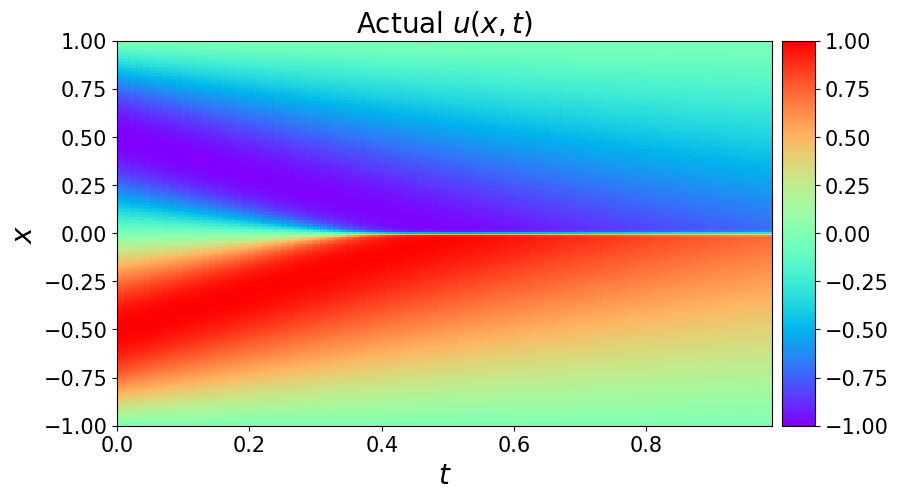

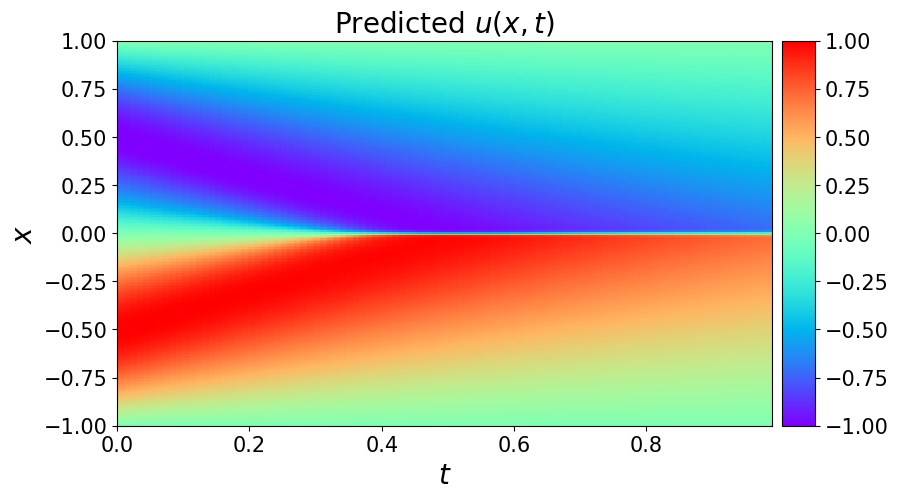

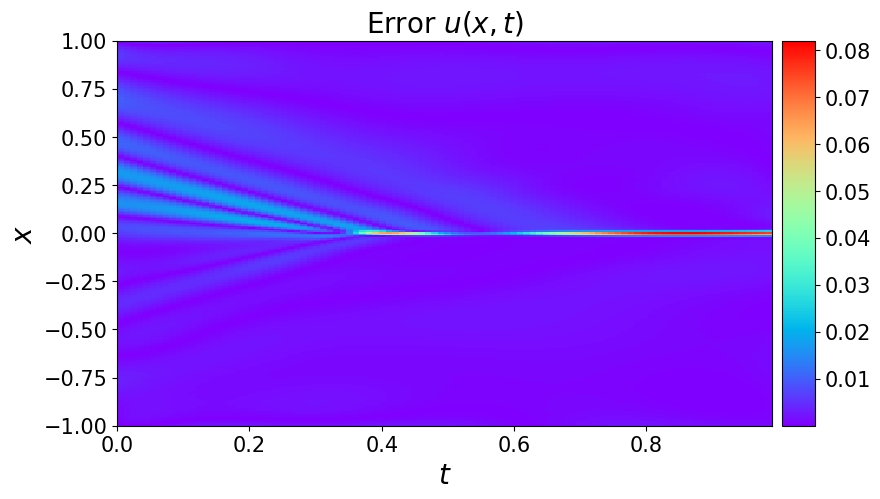

In [10]:
""" The aesthetic setting has changed. """


xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T

# boundary conditions x = lb
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]

# boundary conditions, x = ub
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx2, xx3]) 


####### Row 0: u(t,x) ##################    
X_u_train_ = X_u_train
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]

h = ax.imshow(Exact.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto',vmax=1.0,vmin = -1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

# ax.plot(
#     X_u_train_[:,1], 
#     X_u_train_[:,0], 
#     # 'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
#     markersize = 4,  # marker size doubled
#     clip_on = False,
#     alpha=1.0
# )


ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
# ax.legend(
#     loc='upper center', 
#     bbox_to_anchor=(0.9, -0.05), 
#     ncol=5, 
#     frameon=False, 
#     prop={'size': 15}
# )
ax.set_title('Actual $u(x,t)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto',vmin = -1,vmax = 1.0)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

# ax.plot(
#     X_u_train_[:,1], 
#     X_u_train_[:,0], 
#     markersize = 4,  # marker size doubled
#     clip_on = False,
#     alpha=1.0
# )


ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
# ax.legend(
#     loc='upper center', 
#     bbox_to_anchor=(0.9, -0.05), 
#     ncol=5, 
#     frameon=False, 
#     prop={'size': 15}
# )
ax.set_title('Predicted $u(x,t)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

# plt.show()

####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]

h = ax.imshow(Error.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
            #   vmin = 0,
            #   vmax = 0.5770284271569969)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

# ax.plot(
#     X_u_train_[:,1], 
#     X_u_train_[:,0], 
#     markersize = 4,  # marker size doubled
#     clip_on = False,
#     alpha=1.0
# )


ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
# ax.legend(
#     loc='upper center', 
#     bbox_to_anchor=(0.9, -0.05), 
#     ncol=5, 
#     frameon=False, 
#     prop={'size': 15}
# )
ax.set_title('Error $u(x,t)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

Text(0.5, 1.0, '$t = 0.75$')

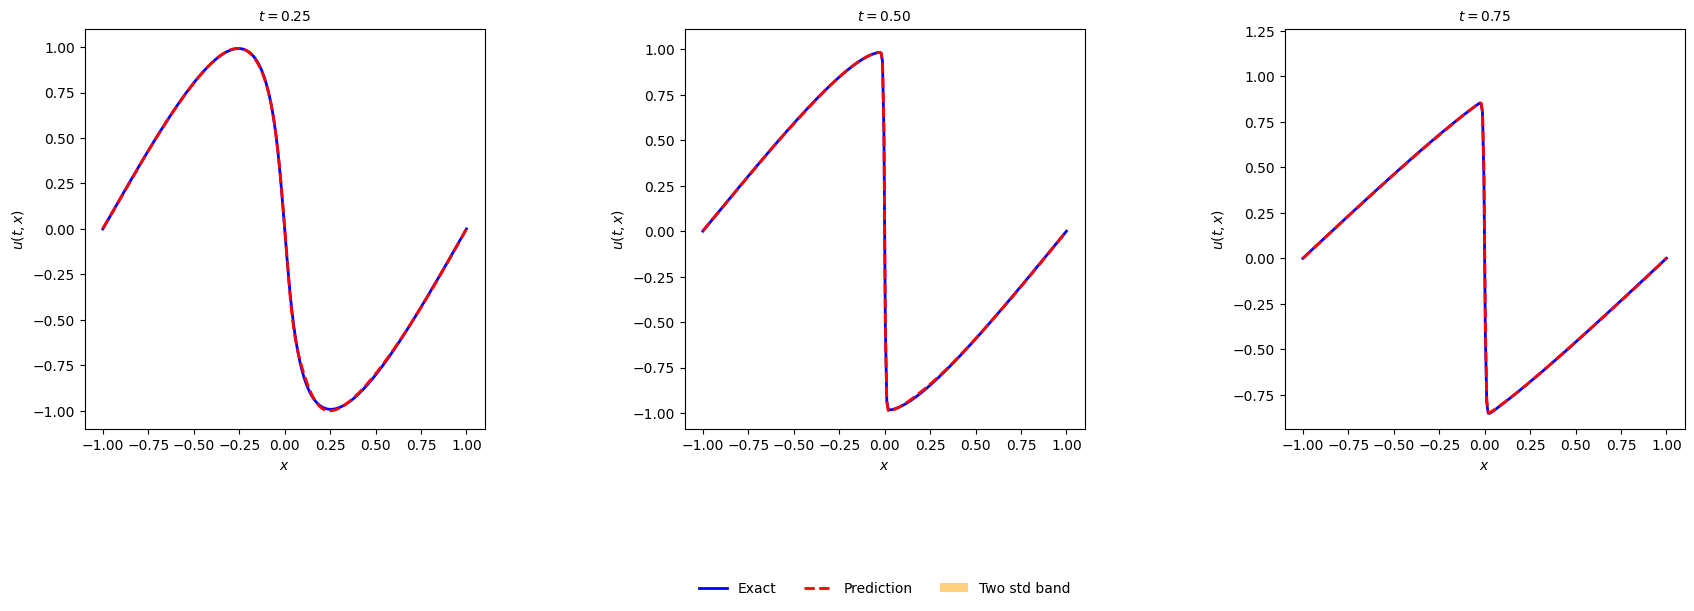

In [11]:
####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
lower = U_pred[25,:] - 2.0*np.sqrt(U_dev[25,:])
upper = U_pred[25,:] + 2.0*np.sqrt(U_dev[25,:])
plt.fill_between(x.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
# ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
lower = U_pred[50,:] - 2.0*np.sqrt(U_dev[50,:])
upper = U_pred[50,:] + 2.0*np.sqrt(U_dev[50,:])
plt.fill_between(x.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
# ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
lower = U_pred[75,:] - 2.0*np.sqrt(U_dev[75,:])
upper = U_pred[75,:] + 2.0*np.sqrt(U_dev[75,:])
plt.fill_between(x.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
# ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 10)

# fig, ax = newfig(1.0)
# ax.axis('off')

In [12]:
st = 0.30
tt = int(t.shape[0] * st)

np.sum(np.abs(np.reshape(Exact[tt,:],(256,1)) - tmp_pred))

2.3634207025740643

In [13]:
b = np.loadtxt('PINN_result.txt',dtype=float)

####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[tt,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,b, 'r--', linewidth = 2, label = 'Prediction')

ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('standard PINNs', fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
# ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[tt,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,tmp_pred, 'r--', linewidth = 2, label = 'Prediction')

ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
# ax.set_ylim([-1.1,1.1])
ax.set_title('PL-PINNs (phase 1)', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[tt,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[tt,:], 'r--', linewidth = 2, label = 'Prediction')

ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
# ax.set_ylim([-1.1,1.1])    
ax.set_title('PL-PINNs (phase 2)', fontsize = 10)
# fig, ax = newfig(1.0)
# ax.axis('off')

FileNotFoundError: PINN_result.txt not found.